In [1]:
import numpy as np
import os, copy, glob, sys

sys.path.append('/home/cchampion/programs/pygromos3')

import pygromos
from pygromos.files.topology.top import Top
from pygromos.files.coord.cnf import Cnf
from pygromos.files.topology.ptp import Ptp

# note: worked well with commit: 7ff90270b8ded0a91f5d9289088075e439bcfff4 of pygromos3_for_reeds

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

from rdkit.Chem import PDBWriter

from datetime import datetime

In [2]:
# imports from my functions

import examples.input_preparation.hybrid_topology_maker as htm

This jupyter notebook will allow to generate a "Hybrid topology" For RE-EDS or TI calculations. 

As input, a user will provide a list of .cnf and .top files of each ligand to be merged/added (note: all parameters need to be the same in the single ligand topologies).

In [3]:
root_dir = '/home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff'

reeds_lig_cnf = root_dir + '/NIK_ligands.cnf'
reeds_complex_cnf = root_dir + '/NIK_complex.cnf'

# How to call your output

name_output = 'NIK_openff'

#### Step 0 : Create "reduced" conformations (individual ligand in water or in complex) from RE-EDS conformation

In [4]:
reduced_cnfs_path = root_dir + '/reduced_conformations'
if not os.path.exists(reduced_cnfs_path): os.mkdir(reduced_cnfs_path)

if not os.path.exists(reduced_cnfs_path+'/ligand_1.cnf'):    
    htm.reduceConformations(path_cnf = reeds_lig_cnf,
                            out_path = reduced_cnfs_path)

if not os.path.exists(reduced_cnfs_path+'/ligand_1_desolv.cnf'):    
    htm.reduceConformations(path_cnf = reeds_lig_cnf,
                            out_path = reduced_cnfs_path, remove_solvent=True)
    
if not os.path.exists(reduced_cnfs_path+'/complex_1.cnf'):        
    htm.reduceConformations(path_cnf = reeds_complex_cnf,
                            out_path = reduced_cnfs_path, contains_protein=True)

those reduces conformations can now be loaded into pyGromos objects as they will be used down the line 

## 1) Maximum common substructure (MCS) search
This first step will find automatically which parts of the ligands to use as the core region.
Note: We will allow the user to manaually determine another code region after this step. 

In [5]:
# Read in the input 

path_dir_tops = root_dir + '/reduced_topologies'

path_cnfs = (glob.glob(reduced_cnfs_path+'/ligand_*_desolv.cnf'))
path_cnfs = sorted(path_cnfs, key = lambda x: int(x.split('.')[0].split('_')[-2]))
cnfs = [Cnf(i) for i in path_cnfs]

path_tops = (glob.glob(path_dir_tops+'/*ligand_*.top'))
path_tops = sorted(path_tops, key = lambda x: int(x.split('.')[0].split('_')[-1]))
tops = [Top(i) for i in path_tops]

In [6]:
mols = [Chem.MolFromPDBBlock(cnf.get_pdb(rdkit_ready=True)) for cnf in cnfs]

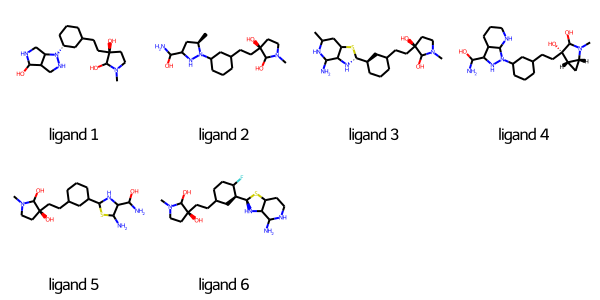

In [7]:
# Draw a 2-D representation of the molecules to make sure everything is ok.
# note protonation state might not be what we want here but this is ok 
# (we will keep exactly same protonation state as in input .cnf/.top).
for mol in mols: AllChem.Compute2DCoords(mol)
Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(150,150),legends=['ligand ' + str(i) for i in range(1, len(mols)+1)])  

#### 1.1a: Perform the MCS
note: manual user involvement may be required to change some of the MCS options to reach desired core

In [8]:
# Perform MCS
mcs = rdFMCS.FindMCS(mols, atomCompare=rdFMCS.AtomCompare.CompareAny, 
                     bondCompare=rdFMCS.BondCompare.CompareAny, 
                     threshold=0.5,  timeout=1,  
                     completeRingsOnly=True, matchValences = True)# , ringMatchesRingOnly=True)

In [9]:
# Otherwise perform MCS without hydrogen 

mols_noh = copy.deepcopy(mols)

mols_noh.append(Chem.MolFromSmiles('CNc(nc1)nc2c1cc(c3c(Cl)cccc3)c(=O)n2CCCN'))

for mol in mols_noh: 
    Chem.RemoveAllHs(mol)

mcs = rdFMCS.FindMCS(mols_noh, threshold=0.5, bondCompare=rdFMCS.BondCompare.CompareAny, completeRingsOnly=True, timeout=1)  


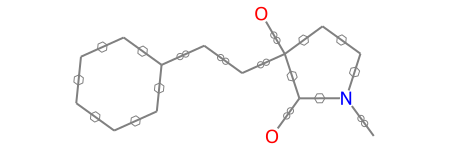

In [10]:
# Otherwise define MCS manually 

smartsString = 'manual'


# Print the stucture to ensure it matches what we want

core = Chem.MolFromSmarts(mcs.smartsString)
#print(mcs.smartsString)
core

#### 1.2: Find the atom mappings of the core based on the MCS found/given

In [11]:
core_mappings = [] # list of mappings to substructures

# This is just for the picture
highlight_bonds = [] 
highlight_atoms = [] 
for mol in mols:
    core_mapping = [i+1 for i in mol.GetSubstructMatch(core)] # +1 important to have numbering from 1 - N
    core_mappings.append(core_mapping)

    hit_ats = list(mol.GetSubstructMatch(core))
    highlight_atoms.append(hit_ats)
    
    hit_bonds = []
    for bond in core.GetBonds():
        aid1 = hit_ats[bond.GetBeginAtomIdx()]
        aid2 = hit_ats[bond.GetEndAtomIdx()]
       
        hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    highlight_bonds.append(hit_bonds)    

#### 1.2b : Redraw what we have with hilighting of the core

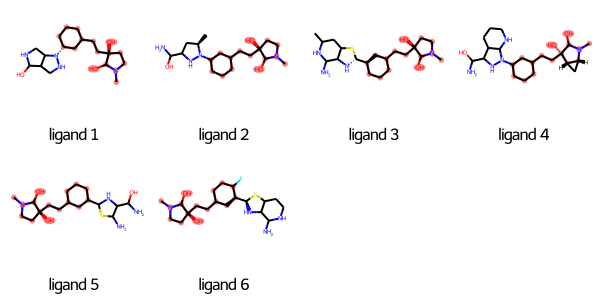

In [12]:
Draw.MolsToGridImage(mols,subImgSize=(150,150), 
                     legends=['ligand ' + str(i) for i in range(1, len(mols)+1)], 
                     highlightAtomLists=highlight_atoms, 
                     highlightBondLists=highlight_bonds,
                     molsPerRow=4,
                     #highlightAtomColors = [] maybe find a lighter color for this later
                    )  

## 2) Make the Hybrid Topology from the atom mapping found 

note: core_mappings variable contains the atom mappings of the core. (List (per ligand) of List of atomIDS that map onto one another, list is ordered)

#### 2.1: Find the "connection point" between core and -R group

In [13]:
force_connecting = [[12], [8], [12], [11], [12], [22]]

connection_points = htm.findConnectionPoints(tops, core_mappings, force_connecting=force_connecting)
connection_points

# Here is how I manually assigned them before
# manual_connection_points = [([12, 13], [36, 15]), ([7, 8], [6, 32]), ([11, 12], [15, 37]), ([1, 10, 11], [14, 2, 36]), ([11, 12], [15, 35]), ([11, 22], [12, 27])]

[([12, 13], [36, 15]),
 ([7, 8], [6, 32]),
 ([11, 12], [15, 37]),
 ([1, 3, 10, 11], [2, 2, 14, 36]),
 ([11, 12], [15, 35]),
 ([11, 22], [12, 27])]

#### 2.2: Initialize the Mapping of the core atoms as a List of PerturbedAtom
The list of PerturbedAtom will be continuously updated during the creation of the Hybrid Topology

In [14]:
# For NIK we need to switch some of the ordering because of symmetry

# TO DO: Automate this process !!! 

core_mappings[1] = [8, 9, 10, 11, 12, 7, 13, 14, 15, 16, 17, 18, 19, 21, 22, 20]
core_mappings[2] = [12, 13, 14, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 26, 27, 1] 
core_mappings[3] = [11, 12, 13, 8, 9, 10, 7, 6, 4, 5, 3, 1, 28, 26, 27, 29]
core_mappings[4] = [12, 13, 14, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 24, 25, 1]
core_mappings[5] = [22, 23, 24, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 25, 26, 1]

core_mappings

[[12, 11, 10, 9, 14, 13, 8, 7, 5, 6, 4, 3, 2, 24, 25, 1],
 [8, 9, 10, 11, 12, 7, 13, 14, 15, 16, 17, 18, 19, 21, 22, 20],
 [12, 13, 14, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 26, 27, 1],
 [11, 12, 13, 8, 9, 10, 7, 6, 4, 5, 3, 1, 28, 26, 27, 29],
 [12, 13, 14, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 24, 25, 1],
 [22, 23, 24, 9, 10, 11, 8, 7, 5, 6, 4, 3, 2, 25, 26, 1]]

In [15]:
perturbed_atoms = htm.initializePerturbedAtoms(tops, core_mappings)
for pa in perturbed_atoms:
    print(pa) 
    pass

atom: C6   initial ligand: 2  initial id: 8   new_id: 12
atom: C7   initial ligand: 2  initial id: 9   new_id: 11
atom: C8   initial ligand: 2  initial id: 10   new_id: 10
atom: C9   initial ligand: 2  initial id: 11   new_id: 9
atom: C10   initial ligand: 2  initial id: 12   new_id: 14
atom: C5   initial ligand: 2  initial id: 7   new_id: 13
atom: C11   initial ligand: 2  initial id: 13   new_id: 8
atom: C12   initial ligand: 2  initial id: 14   new_id: 7
atom: C13   initial ligand: 2  initial id: 15   new_id: 5
atom: O1   initial ligand: 2  initial id: 16   new_id: 6
atom: C14   initial ligand: 2  initial id: 17   new_id: 4
atom: C15   initial ligand: 2  initial id: 18   new_id: 3
atom: N3   initial ligand: 2  initial id: 19   new_id: 2
atom: C17   initial ligand: 2  initial id: 21   new_id: 24
atom: O2   initial ligand: 2  initial id: 22   new_id: 25
atom: C16   initial ligand: 2  initial id: 20   new_id: 1
atom: coreH   initial ligand: 2  initial id: 32   new_id: 36
atom: coreH   i

### 3: Construct the Hybrid Topology and Ptp

note: some warnings may be printed 

In [16]:
out_top_path = path_dir_tops + '/' + name_output + '_hybrid.top'

atom_mappings = htm.constructHybridTopology(tops[0], tops[1:], perturbed_atoms, connection_points, 
                                            path_out_top = out_top_path)

Working on addition of ligand 2 has: 18 atoms.
Working on addition of ligand 3 has: 18 atoms.
Working on addition of ligand 4 has: 22 atoms.
Working on addition of ligand 5 has: 14 atoms.
Working on addition of ligand 6 has: 15 atoms.
 30 1 H5 7 1.008 0.0511 0 1 76 4 31 32 89 90 : does not exist for ligand 4
 32 1 H7 8 1.008 0.0796 0 1 76 2 89 90 : does not exist for ligand 4


### 3bis: Now that ligand topology is made, combine with protein topology

In [17]:
# Append protein to that Topology

protein_top_name = 'NIK_protein.top'

command = "com_top @topo " + out_top_path + '  ' + path_dir_tops + '/' + protein_top_name
command += " @param 1 @solv 1 > " + path_dir_tops + '/' + name_output + '_hybrid_complex.top'

print (command)
os.system(command)

# We can then even follow this by a red_top to regain the nice formatting of the gromos topology
# since it is a hybrid topology, it will understand that 1:a means all ligands as they have bonds between one another.

command2 = "red_top @topo " + path_dir_tops + '/' + name_output + '_hybrid_complex.top @atoms 1:a' 
command2 += ' > ' + path_dir_tops + '/' + name_output + '_hybrid_ligands.top'

print ('\n\n')
print (command2)
os.system(command2)

# remove the previous "tmp" topology which was cleaned up
if os.path.exists(out_top_path):
    os.remove(out_top_path)

com_top @topo /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff/reduced_topologies/NIK_openff_hybrid.top  /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff/reduced_topologies/NIK_protein.top @param 1 @solv 1 > /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff/reduced_topologies/NIK_openff_hybrid_complex.top


NOTE: order of atoms changed in bond:
      45,13 -> 13,45
NOTE: order of atoms changed in bond:
      76,4 -> 4,76
NOTE: order of atoms changed in bond angle:
      41,45,13 -> 13,45,41
NOTE: order of atoms changed in bond angle:
      44,45,13 -> 13,45,44
NOTE: order of atoms changed in bond angle:
      45,13,12 -> 12,13,45
NOTE: order of atoms changed in bond angle:
      45,13,14 -> 14,13,45
NOTE: order of atoms changed in bond angle:
      76,3,4 -> 4,3,76
NOTE: order of atoms changed in bond angle:
      76,3,2 -> 2,3,76
NOTE: order of atoms changed in bond angle:
      76,3,29 -> 29,3,76
NOTE: order of atoms changed in bond angle:
      76,4,5 -> 5,4,76
NOTE: order of atoms changed in bond angle:
      76,4,31 -> 31,4,76
NOTE: order of atoms changed in bond angle:
      111,13,12 -> 12,13,111
NOTE: order of atoms changed in dihedral:
      44,41,13,45 -> 45,13,41,44
NOTE: order of atoms changed in dihedral:
      45,44,13,41 -> 41,13,44,45
NOTE: order of atoms changed in dihedr




red_top @topo /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff/reduced_topologies/NIK_openff_hybrid_complex.top @atoms 1:a > /home/cchampion/work/REEDS/input_preparation/hybrid_topologies/NIK/openff/reduced_topologies/NIK_openff_hybrid_ligands.top


In [19]:
os.system('mv ' + root_dir + '/reduced_topologies/*hybrid* '+ root_dir+'/0_input')

0

### 4: Construct the Hybrid Conformation

In [26]:
# Hybrid cnf for ligands in water
path_cnfs = (glob.glob(reduced_cnfs_path+'/ligand_*.cnf'))
path_cnfs = [p for p in path_cnfs if 'desolv' not in p]
path_cnfs = sorted(path_cnfs, key = lambda x: int(x.split('.')[0].split('_')[-1]))
cnfs = [Cnf(i) for i in path_cnfs]

path_out_cnf = root_dir + '/0_input/' + name_output + '_hybrid_ligands.cnf'
htm.constructHybridConformation(tops[1:], connection_points, cnfs, path_out_cnf)

In [27]:
# Hybrid cnf for ligands in complex
path_out_cnf = root_dir + '/0_input/' + name_output + '_hybrid_complex.cnf'

path_complex_cnfs = sorted(glob.glob(reduced_cnfs_path + '/complex*.cnf'), key = lambda x: int(x.split('.')[0].split('_')[-1]))
complex_cnfs = [Cnf(i) for i in path_complex_cnfs]
htm.constructHybridConformation(tops[1:], connection_points, complex_cnfs, path_out_cnf)

### 4bis:  Construct the Hybrid Conformation with different set of torsions

In [21]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg

def addPosToSolvatedStruct(desolv_cnf, solv_cnf):
    """
    This helper function will simply copy back the conformations from the structure which is de-solvated 
    (for which we rotated the bond) to the solvated structure.
    """
    for atom1, atom2 in zip(desolv_cnf.POSITION, solv_cnf.POSITION):
        atom2.xp = atom1.xp
        atom2.yp = atom1.yp
        atom2.zp = atom1.zp
    return 

mols_withH = [Chem.MolFromPDBBlock(cnf.get_pdb(rdkit_ready=True), removeHs=False) for cnf in cnfs]

cnfs_rotated = copy.deepcopy(cnfs)

# Hybrid cnf for ligands in water
path_cnfs = (glob.glob(reduced_cnfs_path+'/ligand_*.cnf'))
path_cnfs = [p for p in path_cnfs if 'desolv' not in p]
path_cnfs = sorted(path_cnfs, key = lambda x: int(x.split('.')[0].split('_')[-1]))
cnfs_solv = [Cnf(i) for i in path_cnfs]

In [25]:
# Rotate the bond by the desired amount:

# Here the bonds are defined explicitly. 
# This can be played around to change was is desired 


bonds2rot = [(12, 13, 15, 16), 
            (5, 6, 7, 12), 
            (10, 11, 15, 19), 
            (9, 10, 14, 15), 
            (10, 11, 15, 16), 
            (10, 11, 12, 13),]

remove_bond = [(11, 12)]


for idx, (mol, bond2rot) in enumerate(zip(mols_withH, bonds2rot)):
    i, j, k, l = bond2rot
    print (f'working on ligand {idx+1}')
    print (f'{i}-{j}-{k}-{l} ')
    
    # We have to fake removal of a bond here ???  
    #mol = Chem.RWMol(mol)
    #bi, ei = remove_bond[idx]    
    # mol.RemoveBond(bi-1, ei-1, )
    
    current_dih = GetDihedralDeg(mol.GetConformer(0), i-1, j-1, k-1, l-1)
    SetDihedralDeg(mol.GetConformer(0), i-1, j-1, k-1, l-1, current_dih+180)

    cnfs_rotated[idx].createRDKITconf(mol)
    addPosToSolvatedStruct(cnfs_rotated[idx], cnfs_solv[idx])
    
    print ('\n')
    # We will make a hybrid cnf with that data at the end of the file!
    

working on ligand 1
12-13-15-16 


working on ligand 2
5-6-7-12 


working on ligand 3
10-11-15-19 


working on ligand 4
9-10-14-15 


working on ligand 5
10-11-15-16 


working on ligand 6
10-11-12-13 




### Once conformations have been generated, convert to hybrid topology

In [26]:
# Ligands with the rotated torsion 

path_out_cnf = root_dir + '/0_input/' + name_output + '_hybrid_ligands_rotated.cnf'
htm.constructHybridConformation(tops[1:], connection_points, cnfs_solv, path_out_cnf)